Plan 

- Загружаем данные
- Разделить на трайн, тест, валидация. 
- Сделать многоклассовую классификацию.
- Загрузить resnet50 или imagenet
- Сделать обертку, в которую можно загружать разный backbone и дообучать на новые данные. 


In [1]:
import torch 
from torch.utils.data import DataLoader
from torchvision import transforms, models
from time import time
import pandas as pd

import matplotlib.pyplot as plt
from dataset import ImgDataset
from utils import load_data, split_train_test_val

In [2]:
bad_files = pd.read_csv('misplaced_train.csv')
bad_files = set(bad_files['file'])

In [2]:
X, y = load_data(base_dir='data/toloka_imgs')
train, val, test = split_train_test_val(X, y, random_state=42)

In [3]:
len(train[0]), len(val[0]), len(test[0])

(53192, 5911, 6568)

In [5]:
train_filt = ([], [])
for i, el in enumerate(train[0]):
    if el not in bad_files:
        train_filt[0].append(el)
        train_filt[1].append(train[1][i])
train = train_filt

In [7]:
55518 / 61882

0.8971591092724863

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to C:\Users\vlaser/.cache\torch\checkpoints\resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:17<00:00, 10.1MB/s] 


In [4]:
def get_model():
    model = models.resnet50(pretrained=True)
    for param in list(model.parameters())[:-5]:
        param.requires_grad = False
    
    in_features = model.fc.in_features
    model.fc = torch.nn.Sequential(
            torch.nn.Linear(in_features, 8))
            # torch.nn.Softmax())
    
    return model

In [5]:
class Accuracy(torch.nn.Module):
    def __init__(self):
        super(Accuracy, self).__init__()
    
    def forward(self, outputs, targets, multi=True):
        assert outputs.shape == targets.shape
        # print(outputs)
        # print(targets)
        if multi:
            return torch.sum((outputs == targets)).double() / targets.shape[0]
        
        outputs_bin = outputs > 0
        targets_bin = targets > 0

        return torch.sum((outputs_bin == targets_bin)).double()/ targets.shape[0]


In [6]:
def train_one_epoch(model, dataloader, criterion, optimizer, metric, device):
    model.train()
    total_loss = 0.0
    total_acc_multi = 0.0
    total_acc_bin = 0.0
    
    step = 500
    start = time()
    for i, (samples, targets) in enumerate(dataloader):
        samples = samples.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        outputs = model(samples)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        total_acc_multi += metric(preds, targets).item()
        total_acc_bin += metric(preds, targets, multi=False).item()
        total_loss += loss.item()
        
        if (i+1) % step == 0:
            print("Step: {}; {:.2f}.s Loss: {:.4f}; AccMul {:.4f} AccBin {:.4f}".format((i+1), time() - start,
                                                                               (total_loss / (i+1)),
                                                                               (total_acc_multi / (i+1)),
                                                                               (total_acc_bin / (i+1))))
            start = time()
        
    i += 1
    
    total_acc_multi /= i
    total_acc_bin /= i
    total_loss /= i
    return total_loss, total_acc_multi, total_acc_bin

@torch.no_grad()
def eval_model(model, dataloader, criterion, metric, device):
    total_loss = 0
    total_acc_multi = 0.0
    total_acc_bin = 0.0
    model.eval()

    for i, (samples, targets) in enumerate(dataloader):
        samples = samples.to(device)
        targets = targets.to(device)

        outputs = model(samples)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        total_acc_multi += metric(preds, targets).item()
        total_acc_bin += metric(preds, targets, multi=False).item()
        # print(acc_multi, acc_bin)

    i += 1
    total_loss /= i        
    total_acc_multi /= i
    total_acc_bin /= i

    return total_loss, total_acc_multi, total_acc_bin


In [7]:
def train_model(model, dataloaders, criterion, optimizer, metric, device,epochs=10, hist=None):
    if hist is None:
        loss_hist = {'train': [], 'val': []}
        acc_mult_hist = {'train': [], 'val': []}
        acc_bin_hist = {'train': [], 'val': []}
    else:
        loss_hist, acc_mult_hist, acc_bin_hist = hist
        
    start = time()
    for epoch in range(epochs):
        loss, acc_multi, acc_bin = train_one_epoch(model, dataloaders['train'], criterion, optimizer, metric, device)
        loss_hist['train'].append(loss)
        acc_mult_hist['train'].append(acc_multi)
        acc_bin_hist['train'].append(acc_bin)

        print("Epoch [{}/{}] Time: {:.2f}s; Loss: {:.4f}; AccMultiClass: {:.4f}; AccBin: {:.4f} ".format(
                                    epoch + 1, epochs, time() - start, loss, acc_multi, acc_bin))
        
        loss, acc_multi, acc_bin = eval_model(model, dataloaders['val'], criterion, metric, device)
        
        loss_hist['val'].append(loss)
        acc_mult_hist['val'].append(acc_multi)
        acc_bin_hist['val'].append(acc_bin)
        
        print("         Val. Loss: {:.4f}; AccMultiClass: {:.4f}; AccBin: {:.4f} ".format(
                        loss, acc_multi, acc_bin))
        start = time()

    return model, (loss_hist, acc_mult_hist, acc_bin_hist)

In [8]:
data_transform = {
    "train": transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomAffine(degrees=15, scale=(0.9, 1.1)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
    "val": transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
    }

X_train, y_train = train
datasets = {
    "train": ImgDataset(train[0], targets=train[1], transform=data_transform['train']),
    "val": ImgDataset(val[0], targets=val[1], transform=data_transform['val'])
    }
    
dataloaders = {
    "train": DataLoader(datasets['train'], shuffle=True, batch_size=20, num_workers=4),
    "val": DataLoader(datasets['val'], shuffle=False, batch_size=20, num_workers=4)}

In [9]:
class MAEMultiTarget(torch.nn.Module):
    def __init__(self, num_classes=8):
        super(MAEMultiTarget, self).__init__()
        self.num_classes = num_classes
        self.one_hot = torch.eye(self.num_classes)

    def forward(self, outputs, targets):
        one_hot = torch.eye(8).to(targets.device)
        target_one_hot = one_hot.index_select(0, targets)

        return torch.nn.functional.l1_loss(outputs, target_one_hot)



In [10]:
model = get_model()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
metric = Accuracy()

In [10]:
img, target = next(iter(dataloaders['train']))

In [42]:
mdl = get_model()
mdl(img).shape

torch.Size([20, 8])

In [11]:
save_hist = []

In [12]:
model, hist = train_model(model, dataloaders, criterion, optimizer, metric, device, epochs=20)
save_hist.append(hist)

Step: 500; 59.71.s Loss: 0.8120; AccMul 0.7361 AccBin 0.7912
Step: 1000; 52.90.s Loss: 0.7679; AccMul 0.7493 AccBin 0.8022
Step: 1500; 54.56.s Loss: 0.7448; AccMul 0.7539 AccBin 0.8060
Step: 2000; 53.58.s Loss: 0.7270; AccMul 0.7596 AccBin 0.8112
Step: 2500; 53.26.s Loss: 0.7143; AccMul 0.7626 AccBin 0.8137
Epoch [1/20] Time: 291.32s; Loss: 0.7115; AccMultiClass: 0.7637; AccBin: 0.8143
         Val. Loss: 0.6359; AccMultiClass: 0.7793; AccBin: 0.8414
Step: 500; 56.38.s Loss: 0.6509; AccMul 0.7842 AccBin 0.8324
Step: 1000; 51.69.s Loss: 0.6377; AccMul 0.7867 AccBin 0.8351
Step: 1500; 51.56.s Loss: 0.6354; AccMul 0.7888 AccBin 0.8359
Step: 2000; 51.65.s Loss: 0.6309; AccMul 0.7899 AccBin 0.8364
Step: 2500; 51.67.s Loss: 0.6257; AccMul 0.7908 AccBin 0.8366
Epoch [2/20] Time: 279.65s; Loss: 0.6258; AccMultiClass: 0.7901; AccBin: 0.8360
         Val. Loss: 0.5742; AccMultiClass: 0.8037; AccBin: 0.8480
Step: 500; 55.94.s Loss: 0.5859; AccMul 0.8020 AccBin 0.8449
Step: 1000; 51.49.s Loss: 0.5

In [13]:
torch.save(model.state_dict(), 'models/resnet50_filtered.pth')

In [56]:
for param in list(model.parameters())[:-10]:
    param.requires_grad = False

In [14]:
import matplotlib.pyplot as plt

def plot_hist(hist, title, ylabel):
    plt.title(title)
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.plot(hist['train'], label='train')
    plt.plot(hist['val'], label='val')
    plt.legend()
    plt.show()


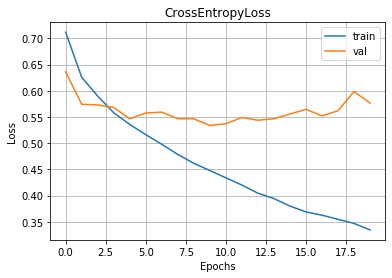

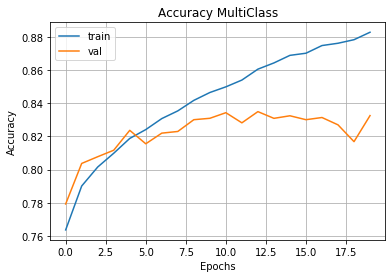

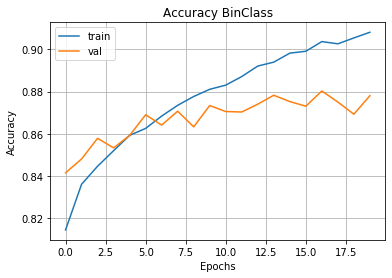

In [15]:
plot_hist(hist[0], 'CrossEntropyLoss', 'Loss')
plot_hist(hist[1], 'Accuracy MultiClass', 'Accuracy')
plot_hist(hist[2], 'Accuracy BinClass', 'Accuracy')

In [16]:
len(list(model.parameters()))

161

$$ y = f(x) $$
$$ \frac{\partial L}{\partial x} = \frac{\partial L}{\partial y} \frac{\partial y}{\partial x} $$ 

$$ GradInput = \frac{\partial L}{\partial x} $$
$$ GradOutput = \frac{\partial L}{\partial y} $$


In [18]:
torch.save(model.state_dict(), "models/resnet50_last5.pth")

In [17]:
dataset_test = ImgDataset(test[0], targets=test[1], transform=data_transform['val'])
dataloader_test = DataLoader(dataset_test, shuffle=False, batch_size=50, num_workers=4)

In [19]:
dataset_train_t = ImgDataset(train[0], targets=train[1], transform=data_transform['val'])
dataloader_train_t = DataLoader(dataset_train_t, shuffle=False, batch_size=50, num_workers=4)

In [18]:
%%time
eval_model(model, dataloader_test, criterion, metric, device)

Wall time: 35.6 s


(0.602134690930446, 0.8182828282828273, 0.8649494949494954)

In [19]:
def get_preds(model, dataloader, device):
    model.eval()
    all_preds = []
    for i, (samples, targets) in enumerate(dataloader):
        samples = samples.to(device)
        targets = targets.to(device)

        outputs = model(samples)
        _, preds = torch.max(outputs, 1)
        all_preds += list(preds.cpu().numpy())
        # print(acc_multi, acc_bin)

    return all_preds

In [20]:
%%time
results = get_preds(model, dataloader_test, device)

Wall time: 35.4 s


In [21]:
import pandas as pd 

In [22]:
df = pd.DataFrame({"file": test[0], "target": test[1], "preds": results})
df

file  target  preds
0          data/toloka_imgs\good_filtered\img_22753.png       0      0
1     data/toloka_imgs\bad_filtered/yellow\img_4972.png       6      4
2     data/toloka_imgs\bad_filtered/yellow\img_6962.png       6      5
3          data/toloka_imgs\good_filtered\img_39318.png       0      0
4          data/toloka_imgs\good_filtered\img_11911.png       0      0
...                                                 ...     ...    ...
6563       data/toloka_imgs\good_filtered\img_45947.png       0      0
6564       data/toloka_imgs\good_filtered\img_44095.png       0      0
6565       data/toloka_imgs\good_filtered\img_30687.png       0      0
6566       data/toloka_imgs\good_filtered\img_34131.png       0      6
6567       data/toloka_imgs\good_filtered\img_15707.png       0      0

[6568 rows x 3 columns]

In [23]:
df[df['target'] == 0]

file  target  preds
0     data/toloka_imgs\good_filtered\img_22753.png       0      0
3     data/toloka_imgs\good_filtered\img_39318.png       0      0
4     data/toloka_imgs\good_filtered\img_11911.png       0      0
5     data/toloka_imgs\good_filtered\img_28662.png       0      0
6     data/toloka_imgs\good_filtered\img_20897.png       0      0
...                                            ...     ...    ...
6563  data/toloka_imgs\good_filtered\img_45947.png       0      0
6564  data/toloka_imgs\good_filtered\img_44095.png       0      0
6565  data/toloka_imgs\good_filtered\img_30687.png       0      0
6566  data/toloka_imgs\good_filtered\img_34131.png       0      6
6567  data/toloka_imgs\good_filtered\img_15707.png       0      0

[4321 rows x 3 columns]

In [24]:
df[df['target'] != 0]

file  target  preds
1     data/toloka_imgs\bad_filtered/yellow\img_4972.png       6      4
2     data/toloka_imgs\bad_filtered/yellow\img_6962.png       6      5
12    data/toloka_imgs\bad_filtered/yellow\img_3133.png       6      6
13    data/toloka_imgs\bad_filtered/yellow\img_6093.png       6      0
21     data/toloka_imgs\bad_filtered/porno\img_6314.png       5      5
...                                                 ...     ...    ...
6547  data/toloka_imgs\bad_filtered/illegal\img_632.png       3      3
6550  data/toloka_imgs\bad_filtered/yellow\img_7905.png       6      6
6553  data/toloka_imgs\bad_filtered/illegal\img_2119...       3      3
6556   data/toloka_imgs\bad_filtered/porno\img_1199.png       5      5
6561    data/toloka_imgs\bad_filtered/porno\img_864.png       5      5

[2247 rows x 3 columns]

In [25]:
# df_bad = df[(df['target'] != df['preds']) & ((df['target'] == 0) | (df['preds'] == 0))]
df_bad = df[(df['target'] != df['preds'])]

In [26]:
df_bad.shape[0]  / df.shape[0]

0.1817904993909866

In [30]:
# df_bad.to_csv('misplaced_train.csv')

In [27]:
from PIL import Image
from os import path
import os

In [28]:
def misplased_save(df):
    classes = ['good', 'casino', 'guns',
    'illegal', 'narcotics', 'porno', 'yellow']
    for class_val in range(len(classes)):
        misplaced = df[df['target'] == class_val]        
        dir_misplased = 'data/toloka_imgs/misplaced_filtered/' + classes[class_val]

        if not os.path.exists(dir_misplased):
            os.makedirs(dir_misplased)
        
        for ind, (filename, tar, pred) in misplaced.iterrows():
            Image.open(filename).save(path.join(dir_misplased, '{}_{}.png'.format(ind, classes[pred])))


In [29]:
misplased_save(df_bad)

In [111]:
classes = ['good', 'casino', 'celebrity', 'guns',
    'illegal', 'narcotics', 'porno', 'yellow']
class_val = 0

In [112]:
misplaced = df[df['target'] == class_val]

In [113]:
misplaced

file  target  preds
28    data/toloka_imgs\good\img_15121.png       0      4
35     data/toloka_imgs\good\img_6205.png       0      1
45    data/toloka_imgs\good\img_16551.png       0      7
56      data/toloka_imgs\good\img_813.png       0      3
76     data/toloka_imgs\good\img_4495.png       0      1
...                                   ...     ...    ...
3207  data/toloka_imgs\good\img_16618.png       0      7
3211  data/toloka_imgs\good\img_16634.png       0      2
3216   data/toloka_imgs\good\img_6743.png       0      1
3221  data/toloka_imgs\good\img_13329.png       0      6
3228   data/toloka_imgs\good\img_3836.png       0      7

[211 rows x 3 columns]

In [107]:
dir_misplased = 'data/toloka_imgs/misplaced_' + classes[class_val]


In [109]:
for ind, (filename, tar, pred) in misplaced.iterrows():
    Image.open(filename).save(path.join(dir_misplased, '{}_{}.png'.format(ind, classes[pred])))
    # print((ind, filename, tar, pred))

In [110]:
misplaced['preds'].value_counts()

0    68
1    30
2    13
6    11
3     7
4     3
5     2
Name: preds, dtype: int64

In [58]:
img, target = next(iter(dataloader))
img = img[0].numpy()
img = img.reshape(img.shape[1:]).transpose(1, 2, 0)

ValueError: cannot reshape array of size 150528 into shape (224,224)

In [14]:
print(target)
plt.imshow(img)

tensor([3])


In [142]:
import numpy as np

In [106]:
class Accuracy(torch.nn.Module):
    def __init__(self):
        super(Accuracy, self).__init__()
    
    def forward(self, outputs, targets, multi=True):
        if multi:
            return torch.sum((outputs == targets)).type(torch.DoubleTensor) / outputs.shape[0]
        
        outputs_bin = outputs != 0
        targets_bin = targets != 0

        return (outputs_bin == targets_bin).sum().type(torch.DoubleTensor) / outputs.shape[0]

In [107]:
acc = Accuracy()

In [115]:
output = torch.tensor([7, 0, 0, 5, 1, 0, 0, 0, 0, 0])
acc(output, target, multi=True).item()

1.0

In [148]:
_, preds = torch.max(torch.tensor(np.eye(5)), 1)
preds

tensor([0, 1, 2, 3, 4])